In [ ]:
# Import all necessary libraries at the top
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# חלק 1: הערת הסביבה וקריאת הנתונים


החלק הראשון טוען את הסביבה שלך נתיב של הפרוייקט:
- קריאת קובץ הנתונים.
- הצגת מבנה הנתונים.


In [ ]:
# Load the data
file_path = '/content/drive/MyDrive/BINA PROJECT/Filtered_COVID_Severity_Dataset.csv'
data = pd.read_csv(file_path)

# Display general information and the first rows of the data
print("מספר הסטים:")
data.info()
data.head()

מספר הסטים:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237600 entries, 0 to 237599
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Fever                    237600 non-null  int64
 1   Tiredness                237600 non-null  int64
 2   Dry-Cough                237600 non-null  int64
 3   Difficulty-in-Breathing  237600 non-null  int64
 4   Sore-Throat              237600 non-null  int64
 5   None_Sympton             237600 non-null  int64
 6   Pains                    237600 non-null  int64
 7   Nasal-Congestion         237600 non-null  int64
 8   Runny-Nose               237600 non-null  int64
 9   Diarrhea                 237600 non-null  int64
 10  None_Experiencing        237600 non-null  int64
 11  Age_0-9                  237600 non-null  int64
 12  Age_10-19                237600 non-null  int64
 13  Age_20-24                237600 non-null  int64
 14  Age_25-59               

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Contact_Dont-Know,Contact_No,Contact_Yes,Severity
0,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
1,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
2,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,1,0,1,0,0,0
3,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,1,0,0,0,1,1
4,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,1,0,0,1,0,1


# חלק 2: עיבוד וחלוקה לסטים

בקוד זה נעשית חלוקה של הנתונים לקבוצות אימון, אימות, ובדיקה.
- סט אימון: 70%.
- סט אימות: 15%.
- סט בדיקה: 15%.



In [ ]:
# Separate features and target
target = 'Severity'
X = data.drop(columns=[target])
y = data[target]

# Ensure target values are in the range [0, 2]
# No subtraction needed if values are already in the correct range

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("מספר הסטים:")
print(f"Train: {len(X_train)}\nValidation: {len(X_val)}\nTest: {len(X_test)}")


מספר הסטים:
Train: 166320
Validation: 35640
Test: 35640


# חלק 3: בניית המודל

המודל נבנה ומשלב את הטכניקות של למידה עמוקה (שכבות, נרמול).



In [ ]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output layer for 3-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# חלק 4: קומפילציה והגדרת קולבקים

- Adam משמש כקצב למידה.
- ReduceLROnPlateau להורדת ה-Learning Rate כשאין שיפור.
- EarlyStopping לעצירה מוקדמת כשהביצועים מפסיקים להשתפר.


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# חלק 5: אימון המודל

האימון מתבצע עם Callbacks שמבטיחים מעקב ושיפור במהלך התהליך.

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.3313 - loss: 1.1908 - val_accuracy: 0.3338 - val_loss: 1.0996 - learning_rate: 0.0010
Epoch 2/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3333 - loss: 1.1002 - val_accuracy: 0.3284 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 3/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.3342 - loss: 1.0994 - val_accuracy: 0.3329 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 4/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.3349 - loss: 1.0991 - val_accuracy: 0.3335 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 5/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3334 - loss: 1.0988 - val_accuracy: 0.3335 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 6/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.3321 - loss: 1.0988 - val_accuracy: 0.3341 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 7/25
5198/5198 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.3

# חלק 6: הערכת המודל

בדיקת ביצועי המודל על סט הבדיקה.
בנוסף ל-Accuracy מתבצע שימוש במדדי Precision, Recall, ו-F1-Score.

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test).argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
report = classification_report(y_test, y_pred, target_names=['Mild', 'Moderate', 'Severe'])
print("Classification Report:\n", report)

1114/1114 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.3317620650953984
Classification Report:
               precision    recall  f1-score   support

        Mild       0.33      0.17      0.23     11911
    Moderate       0.33      0.07      0.11     11852
      Severe       0.33      0.75      0.46     11877

    accuracy                           0.33     35640
   macro avg       0.33      0.33      0.27     35640
weighted avg       0.33      0.33      0.27     35640



# חלק 7: הצגת גרפים

ציור ה-Loss וה-Accuracy במשך ה-Epochs כדי לעקוב אחר מקרים של Overfitting.

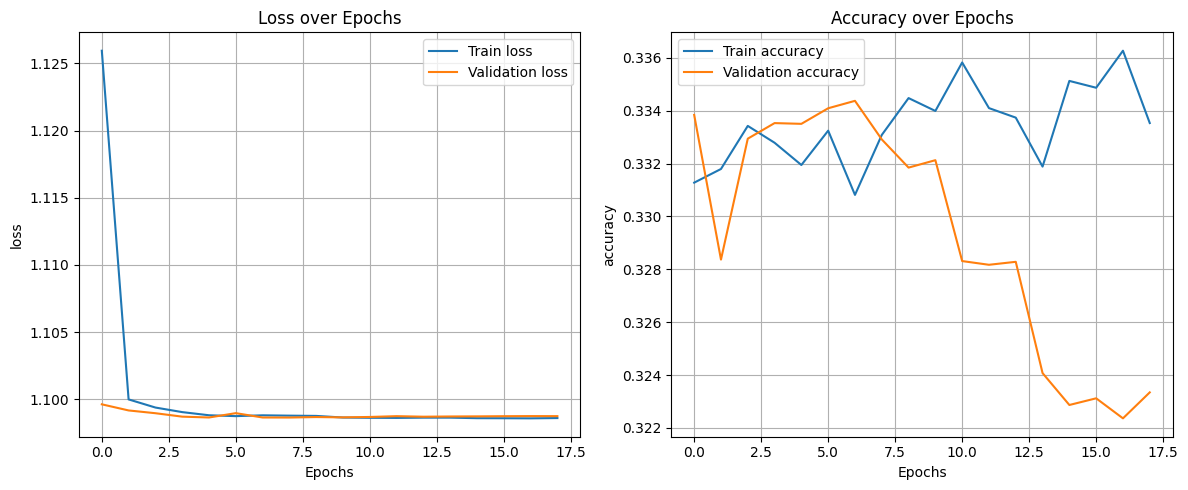

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

def plot_history(history, metric, title):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()

# Loss over epochs
plt.subplot(1, 2, 1)
plot_history(history, 'loss', 'Loss over Epochs')

# Accuracy over epochs
plt.subplot(1, 2, 2)
plot_history(history, 'accuracy', 'Accuracy over Epochs')

plt.tight_layout()
plt.show()